In [1]:
import os
import subprocess
import matplotlib
matplotlib.interactive(True)
import matplotlib.pyplot as plt

geomstats_gitroot_path = subprocess.check_output(
    ['git', 'rev-parse', '--show-toplevel'],
    universal_newlines=True)

os.chdir(geomstats_gitroot_path[:-1])

print('Working directory: ', os.getcwd())

import geomstats.backend as gs

gs.random.seed(2021)

Working directory:  /home/curt/projects/python-first


INFO: Using numpy backend


In [2]:
N_ELECTRODES = 8
N_SIGNS = 4

In [3]:
import geomstats.datasets.utils as data_utils

data = data_utils.load_emg()

In [4]:
data.head()

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
0,23,127,123,128,134,125,128,130,124,rest,mg_s1
1,28,126,130,128,119,129,128,126,133,rest,mg_s1
2,32,129,130,127,125,129,129,127,130,rest,mg_s1
3,36,127,128,126,123,128,127,125,131,rest,mg_s1
4,40,127,128,129,124,127,129,127,128,rest,mg_s1


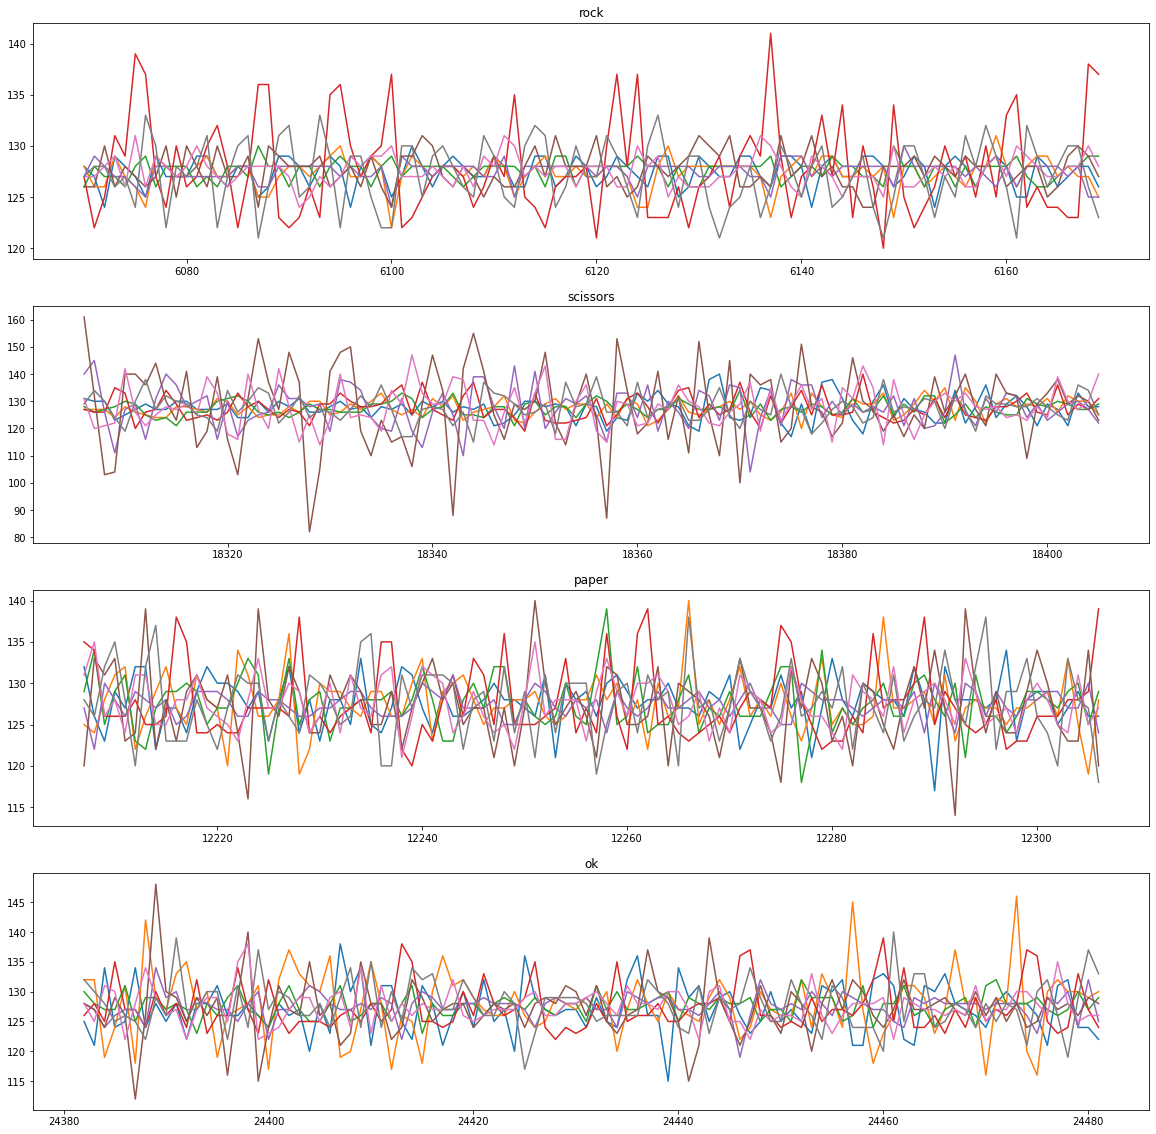

In [5]:
fig, ax = plt.subplots(N_SIGNS, figsize=(20, 20))
label_list = ['rock', 'scissors', 'paper', 'ok']
for i, label_i in enumerate(label_list):
    sign_df = data[data.label==label_i].iloc[:100]
    for electrode in range(N_ELECTRODES):
        ax[i].plot(sign_df.iloc[:, 1 + electrode])
        ax[i].title.set_text(label_i)

In [6]:
data = data[data.label != 'rest']

In [7]:
import numpy as np
import pandas as pd

### Parameters.
N_STEPS = 100
LABEL_MAP = {'rock': 0, 'scissors': 1, 'paper': 2, 'ok': 3}
MARGIN = 1000

In [8]:
data_dict = {
    'time': gs.array(data.time),
    'raw_data': gs.array(data[['c{}'.format(i) for i in range(N_ELECTRODES)]]),
    'label': gs.array(data.label),
    'exp': gs.array(data.exp)}


In [9]:
from geomstats.datasets.prepare_emg_data import TimeSeriesCovariance

cov_data = TimeSeriesCovariance(data_dict, N_STEPS, N_ELECTRODES, LABEL_MAP, MARGIN)
cov_data.transform()

In [10]:
import geomstats.geometry.spd_matrices as spd

manifold = spd.SPDMatrices(N_ELECTRODES)

In [11]:
gs.all(manifold.belongs(cov_data.covs))

True

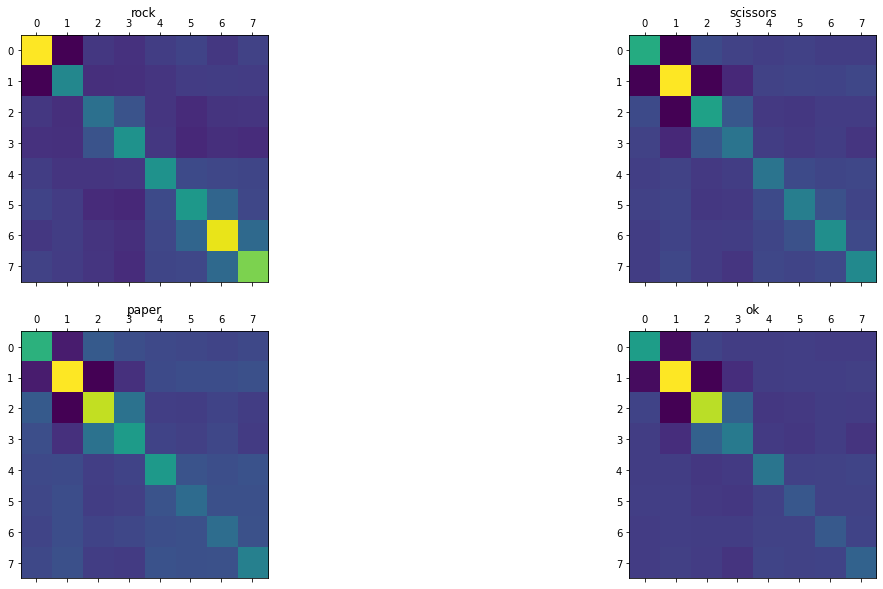

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_cov = np.mean(sign_cov_mat, axis=0)
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

## Covariances plot of the Frechet Mean of the affine invariant metric

In [13]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.spd_matrices import SPDMetricAffine

In [14]:
metric_affine = SPDMetricAffine(N_ELECTRODES)
mean_affine = FrechetMean(metric=metric_affine, point_type='matrix')

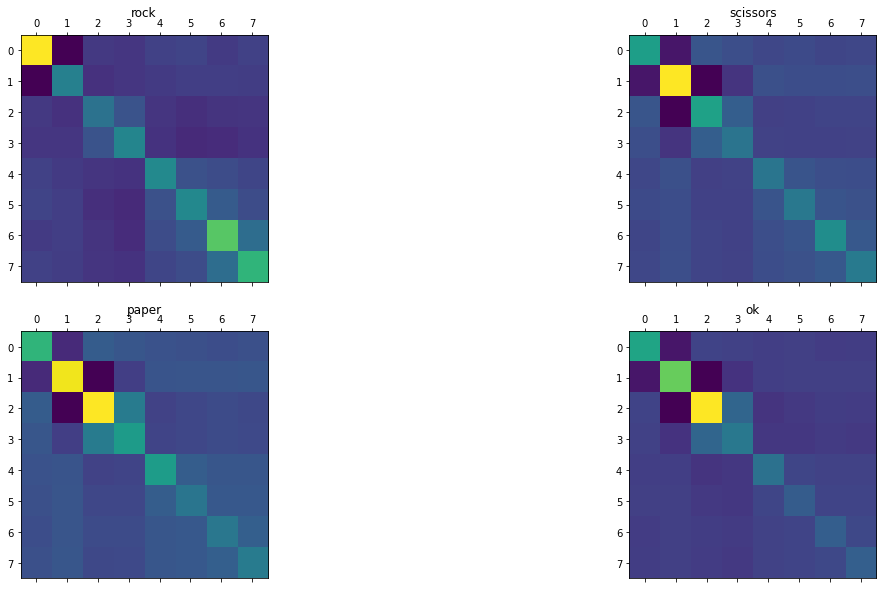

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_affine.fit(X=sign_cov_mat)
    mean_cov = mean_affine.estimate_
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

# Sign Classification

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [17]:
# Hiding the numerous sklearn warnings
import warnings
warnings.filterwarnings('ignore')

In [18]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

In [19]:
N_EPOCHS = 10
N_FEATURES = int(N_ELECTRODES * (N_ELECTRODES + 1) / 2)

In [20]:
class ExpResults:
    """Class handling the score collection and plotting among the different experiments.
    """

    def __init__(self, exps):
        self.exps = exps
        self.results = {}
        self.exp_ids = {}
        # Compute the index corresponding to each session only once at initialization.
        for exp in set(self.exps):
            self.exp_ids[exp] = np.where(self.exps==exp)[0]

    def add_result(self, model_name, model, X, y):
        """Add the results from the cross validated pipeline.

        For the model 'pipeline', it will add the cross validated results of every session in the model_name
        entry of self.results.

        Parameters
        ----------
        model_name : str
            Name of the pipeline/model that we are adding results from.
        model : sklearn.pipeline.Pipeline
            sklearn pipeline that we are evaluating.
        X : array
            data that we are ingesting in the pipeline.
        y : array
            labels corresponding to the data.
        """
        self.results[model_name] = {'fit_time': [], 'score_time': [], 'test_score': [], 'train_score': []}
        for exp in self.exp_ids.keys():
            ids = self.exp_ids[exp]
            exp_result = cross_validate(pipeline, X[ids], y[ids], return_train_score=True)
            for key in exp_result.keys():
                self.results[model_name][key] += list(exp_result[key])
        print('Average training score: {:.4f}, Average test score: {:.4f}'.format(
            np.mean(self.results[model_name]['train_score']),
            np.mean(self.results[model_name]['test_score'])))

    def plot_results(self, title, variables, err_bar=None, save_name=None, xlabel='Model', ylabel='Acc'):
        """Plot bar plot comparing the different pipelines' results.

        Compare the results added previously using the 'add_result' method with bar plots.

        Parameters
        ----------
        title : str
            Title of the plot.
        variables : list of array
            List of the variables to plot (e.g. train_score, test_score,...)
        err_bar : list of float
            list of error to use for plotting error bars. If None, std is used by default.
        save_name : str
            path to save the plot. If None, plot is not saved.
        xlabel : str
            Label of the x-axis.
        ylabel : str
            Label of the y-axis.
        """
        ### Some defaults parameters.
        w = 0.5
        colors = ['b', 'r', 'gray']

        ### Reshaping the results for plotting.
        x_labels = self.results.keys()
        list_vec = []
        for variable in variables:
            list_vec.append(np.array([self.results[model][variable] for model in x_labels]).transpose())
        rand_m1 = lambda size: np.random.random(size) * 2 - 1

        ### Plots parameters.
        label_loc = np.arange(len(x_labels))
        center_bar = [w * (i - 0.5) for i in range(len(list_vec))]

        ### Plots values.
        avg_vec = [np.nanmean(vec, axis=0) for vec in list_vec]
        if err_bar is None:
            err_bar = [np.nanstd(vec, axis=0) for vec in list_vec]

        ### Plotting the data.
        fig, ax = plt.subplots(figsize=(20, 15))
        for i, vec in enumerate(list_vec):
            label_i = variable[i] + ' (n = {})'.format(len(vec))
            rects = ax.bar(label_loc + center_bar[i], avg_vec[i], w, label=label_i,
                           yerr=err_bar[i], color=colors[i], alpha=0.6)
            for j, x in enumerate(label_loc):
                ax.scatter((x + center_bar[i]) + rand_m1(vec[:, j].size) * w/4,
                           vec[:, j], color=colors[i], edgecolor='k')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(label_loc)
        ax.set_xticklabels(x_labels)
        ax.legend()
        plt.legend()

        ### Saving the figure with a timestamp as a name.
        if save_name is not None:
            plt.savefig(save_name)

In [21]:
exp_arr = data.exp.iloc[cov_data.batches]
intra_sessions_results = ExpResults(exp_arr)

In [22]:
pipeline = Pipeline(
    steps=[('standardize', StandardScaler()),
           ('logreg', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])

intra_sessions_results.add_result(model_name='logreg_eucl', model=pipeline, X=cov_data.covecs, y=cov_data.labels)

Average training score: 0.9937, Average test score: 0.9165


In [23]:
def create_model(weights='initial_weights.hd5', n_features=N_FEATURES, n_signs=N_SIGNS):
    """Function to create model, required for using KerasClassifier and wrapp a Keras model inside a
    scikitlearn form.
    We added a weight saving/loading to remove the randomness of the weight initialization (for better comparison).
    """
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_features, activation='relu', input_shape=(n_features,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_signs, activation='softmax'),
])

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=N_FEATURES)

In [24]:
generate_weights = create_model(weights=None)

In [25]:
pipeline = Pipeline(
    steps=[('standardize', StandardScaler()),
           ('mlp', KerasClassifier(build_fn=create_model, epochs=N_EPOCHS, verbose=0))])

intra_sessions_results.add_result(model_name='mlp_eucl', model=pipeline, X=cov_data.covecs, y=cov_data.labels)

Average training score: 0.9467, Average test score: 0.8158


In [26]:
from geomstats.learning.preprocessing import ToTangentSpace

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric_affine)),
           ('standardize', StandardScaler()),
           ('logreg', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])

intra_sessions_results.add_result(model_name='logreg_affinvariant_tangent', model=pipeline, X=cov_data.covs, y=cov_data.labels)

Average training score: 0.9959, Average test score: 0.9195


In [27]:
pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric_affine)),
           ('standardize', StandardScaler()),
           ('mlp', KerasClassifier(build_fn=create_model_covariance, epochs=N_EPOCHS, verbose=0))])

intra_sessions_results.add_result(model_name='mlp_affinvariant_tangent', model=pipeline, X=cov_data.covs, y=cov_data.labels)

Average training score: 0.9663, Average test score: 0.8288


In [28]:
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.geometry.spd_matrices import SPDMetricEuclidean

pipeline = Pipeline(
    steps=[('clf', RiemannianMinimumDistanceToMeanClassifier(
        riemannian_metric=SPDMetricEuclidean(n=N_ELECTRODES),
        n_classes=N_SIGNS))])

intra_sessions_results.add_result(model_name='mdm_eucl', model=pipeline, X=cov_data.covs, y=cov_data.labels)

ModuleNotFoundError: No module named 'geomstats.learning.mdm'

In [ ]:
pipeline = Pipeline(
    steps=[('clf', RiemannianMinimumDistanceToMeanClassifier(
        riemannian_metric=SPDMetricAffine(n=N_ELECTRODES),
        n_classes=N_SIGNS))])

intra_sessions_results.add_result(model_name='mdm_affinvariant', model=pipeline, X=cov_data.covs, y=cov_data.labels)

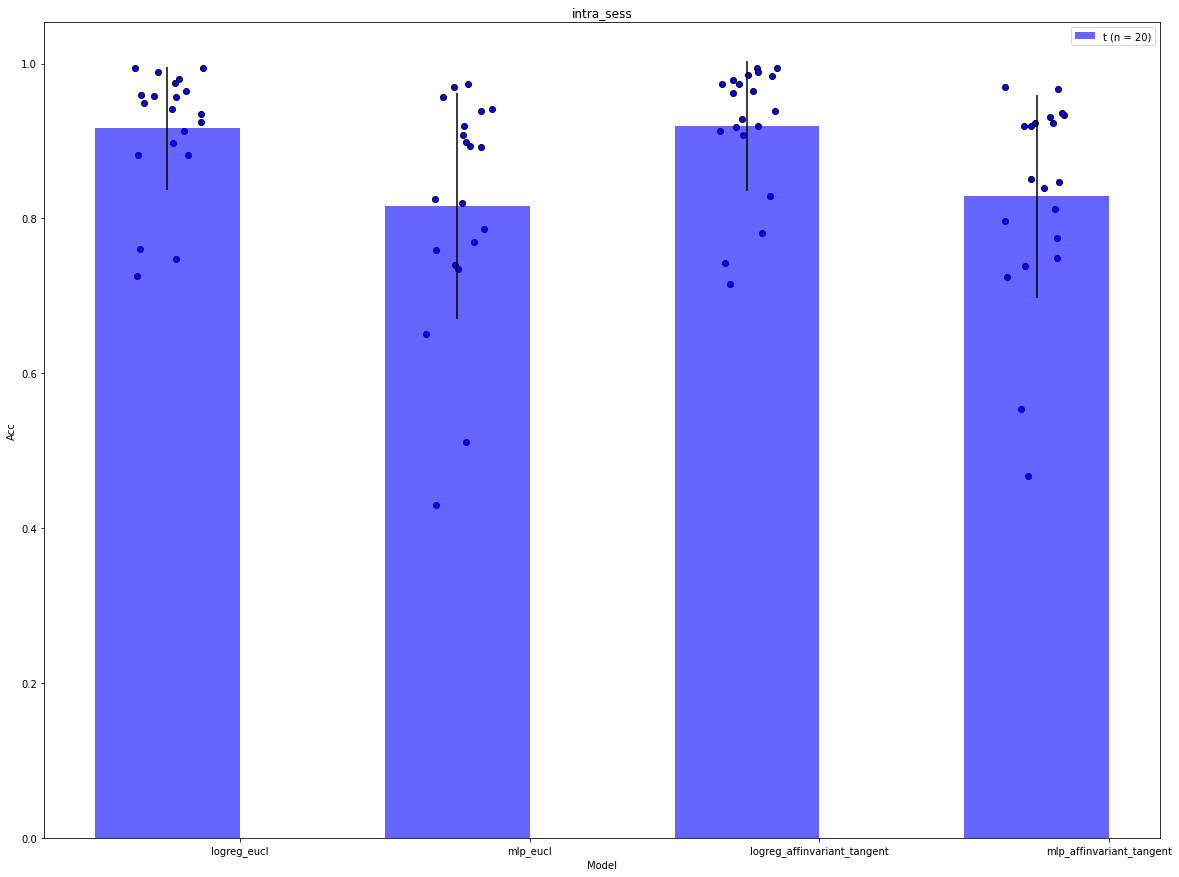

In [29]:
intra_sessions_results.plot_results('intra_sess', ['test_score'])